# Analyzing European Club Soccer Data
*Johnny Antoun*, *Jackie Du*, *Richard Fremgen*, *Jose Pilego San Martin*

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import auc, roc_curve, RocCurveDisplay

from functions.plot_fxns import draw_soccer_pitch, plot_pass_length_heatmap, plot_pass_by_country, plot_pass_by_country_role, plot_freq_pass
from functions.passing_data_fxns import get_pass_shot_data, get_summary_pass_data
from functions.main import make_angle, make_distance

## I. Introduction

Soccer. Football. Fútbol. Fußball. However you pronounce the sport, soccer is widely regarded as the world’s most popular, with an estimated 4 billion fans across the globe. At the center of the men’s sport is the FIFA World Cup, an international quadrennial soccer competition where over 200 countries compete to qualify for one of the 32 spots that make the final tournament. This year being a World Cup year, coupled with our team members being avid fans of the game was the driving motivation for deciding to center this project around the analysis of a soccer dataset. The data used in this project is taken from an [opensource project](https://www.nature.com/articles/s41597-019-0247-7) that created soccer logs to record every spatio-temporal match event that took place during the 2017-2018 club soccer seasons in England, France, Germany, Spain, and Italy. For every league game that occurred, each individual match event (e.g., shots, fouls, passes, duels) was recorded, along with the time and location on the pitch for which it took place. From this data, one can begin to deduce analytically how a particular team or league strategize and score goals. 

On a fundamental level, a soccer match is won by simply scoring more goals than your opponent. Thus, gametime tactics revolve around increasing a team’s probability of scoring, as player position and angle relative to the opposing goal are imperative when trying to maximize the odds of one scoring. Due to the immense dimensions of a soccer goal (8 ft by 24 ft), professional goalkeepers are trained to cut off or reduce the angle when an opposing player has the ball near the penalty area. Watch any professional goalkeeper play and you will see that they constantly adjust their position and angle relative to the play, rather than just stand on the goal line. With that in mind, our team was first interested in building an expected goals model to calculate the likelihood of scoring from different areas and angles on the pitch. This model could then be used to compare player and team performance for the given season. 

While goals in soccer are usually the most memorable parts of the game, passes are the connective tissue that create all goal scoring opportunities. It is widely known that different countries historically employ different methodologies of play and passing styles to best increase their chances of winning. The World Cup is the best evidence of such a feat, a match between England vs. Spain will reveal a multitude of differences between attacking styles and the types of passes made. A generic comparison of the different styles is below:
* **England**: less reliance on technique and more focus on physicality, with emphasis on long balls and set pieces.

* **Italy**: generally slower and tactical with older players; heavy emphasis on good defensive play.

* **Germany**: efficient, attacking football; teams are generally well-organized, professional, resourceful, and clinical.

* **Spain**: emphasizes keeping possession and creating space through movement. Generally the players in Spain have more time on the ball, allowing them to show the technical side of their game. 

* **France**: mix of the different styles of play of the other top 4 leagues.

While collecting data on each international's team game performance is one approach to validate whether a particular country truly plays a particular style of play, the problem with international soccer is that it happens so infrequently, making data collection a challenge to obtain an adequate sample size. Rather than trying to extrapolate from only a handful of games for each country, we decided to use the soccer log dataset to evaluate differences with how each league plays the game from a passing perspective. Then we can observe whether or not such passing patterns for each league coincide with the traditional tactics employed by the native country style of play. Using the league data provides an adequate sample size for comparison, since each leagues consists for 18 or 20 teams, that each play one another twice a season, all of which is collected in our dataset.

## II. File Structure

This file contains the final report writeup, model assessment, and visualizations. This repo also contains the `/data` folder which contains both the raw json and csv data, as well as the `/data/processed` folder which contains the cleaned and merged data ready to be used for the expected goals model. This cuts down the runtime for this file, but we decided clean and process the passing section analysis at runtime, since the file sizes were too large for directly uploading to git. The repo also contains a `/functions` folder which contains all the functions needed for processing data and visualizations for both of the subsequent sections. We make the functions folder into a package and import the functions from their corresponding modules. 

## III. Expected Goals Model

Expected goals is a statistical measure that tries to give a more fair assessment than raw scored goals. Since soccer is a low-scoring sport, the final result is often not a good summary of how the game developed.

An expected goals model assigns a probability score to each shot. This score approximates the probability of the given shot resulting in a goal. With these probability scores, analysts can draw stronger conclusions on team or individual performance.

### Data Cleaning

We use the event data to build the model. First, we filter for shots and extract information on whether each shot was a goal or not. This information is contained in the `tags` column, which also has additional shot characteristics like whether the shot was a header or not, with which foot the player took the shot, if the shot originated from a counter attack, etc.

Based on the shot coordinates, we create two additional features. First, we calculate the distance from the shot origin to the center of the goal. We also calculate the angle between the shot origin and the inner box. Intuitively, a small angle means that the player did not have a clear view of the goal. We do the angle calculation with the inner box because we do not know the positions of the posts in the pitch and the angle defined with the inner box is similar to the angle defined with the goal (in a statistical sense, at least).

The cleaning is done in the file `dt_shots.py` and this file imports the function `make_shot_df()` in `main.py`.

In [2]:
dt_shots = pd.read_pickle('data/processed/dt_shots.pkl')
# Convert coordinates to use the draw_pitch() function
dt_shots['start_x'] = dt_shots['start_x']/105 * 120
dt_shots['start_y'] = dt_shots['start_y']/68 * 90

with open("data/players.json", encoding="unicode_escape") as f:
    df_players = pd.read_json(f.read())
    
df_players = df_players.rename(columns={'wyId': 'playerId'})

### Exploratory Data Analysis

First, we look at all the shots taken, colored by whether they were goals or not. We can see that the majority of shots are not goals (as expected) and that most of the shots are taken inside the last 75% of the pitch.

There are some outlying shots outside the point cloud. It is interesting to note that many of the shots that are taken from very far away result in goals. This could be because the player takes a shot knowing that the goalkeeper is out of position, usually in the late minutes of the match when the goalkeeper goes to the opponent box in a desperate try to tie the game. For this reason, we use only shots that are taken inside the last 70% of the pitch.

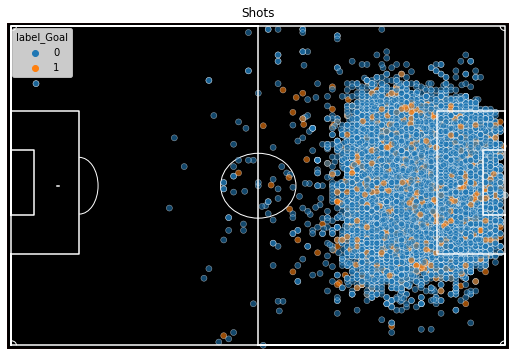

In [3]:
draw_soccer_pitch()
fig = sns.scatterplot(
    x='start_x',
    y='start_y',
    data=dt_shots,
    hue='label_Goal',
    alpha=0.6
)
fig.set_title('Shots')
plt.show()

We now look at the distribution of distance and angle, grouped by whether or not the shot is a goal. There are no obvious differences in the shape of the distributions.

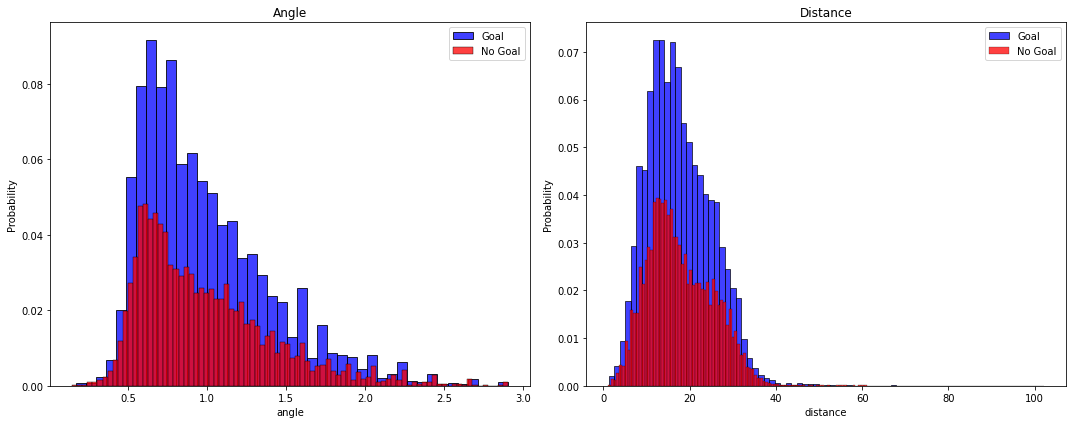

In [4]:
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(
    dt_shots[dt_shots['label_Goal'] == 1]['angle'],
    color='b',
    stat='probability'
)
sns.histplot(
    dt_shots[dt_shots['label_Goal'] == 0]['angle'],
    color='r',
    stat='probability'
)
plt.title('Angle')
plt.legend(labels=['Goal', 'No Goal'])
plt.subplot(1, 2, 2)
sns.histplot(
    dt_shots[dt_shots['label_Goal'] == 1]['distance'],
    color='b',
    stat='probability'
)
sns.histplot(
    dt_shots[dt_shots['label_Goal'] == 0]['distance'],
    color='r',
    stat='probability'
)
plt.title('Distance')
plt.legend(labels=['Goal', 'No Goal'])
plt.tight_layout()
plt.show()

As a sanity check, we plot the shots colored by the angle (in radians). As expected, we see that shots that are closer to the goal and closer to the middle of the pitch (vertically) have larger angles than those further away or to the sides.

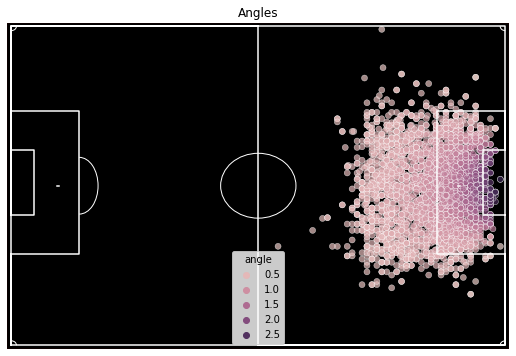

In [5]:
draw_soccer_pitch()
sns.scatterplot(
    data=dt_shots.iloc[1:3000, :], x='start_x', y='start_y', hue='angle', alpha=0.7
)
plt.title('Angles')
plt.show()

### Model

Since we expect non-linear interactions between the variables, we use a random forest to model the probabilities. We set it up as a binary classification task where the response is whether or not the shot was a goal. To evaluate the model we use the area under the ROC curve because we are more interested in the probability scores than in the actual classification labels.

We split the data into a training and a test set based on a stratified sample. We stratify because no-goals are much more prevalent in the data. To set the hyperparameters we use stratified k-fold cross validation and a grid search. We only show the final model here, but the complete procedure can be found in the `xg_model.py` file.

In [6]:
# Select relevant features
dt_shots = dt_shots[[
    'start_x', 'start_y', 'label_Left', 'label_Right', 'label_counter_attack',
    'label_head/body', 'label_interception', 'angle', 'distance', 'label_Goal'
]].dropna()

# Exclude shots taken from too far away
dt_shots = dt_shots[dt_shots['start_x'] > 70*105.0/100.0]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    dt_shots.drop('label_Goal', axis=1), dt_shots.label_Goal, test_size=0.2,
    random_state=42,
    stratify=dt_shots.label_Goal
)

In [7]:
# Final model after cross-validation
final_rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    max_features=9,
    n_jobs=2,
    min_samples_split=500,
    random_state=42,
    verbose=0
)

final_rf_fit = final_rf.fit(X_train, y_train)

The model achieves an AUC-ROC of 0.71 which is much better than random guessing and better than we got with other modeling approaches like logistic regression.

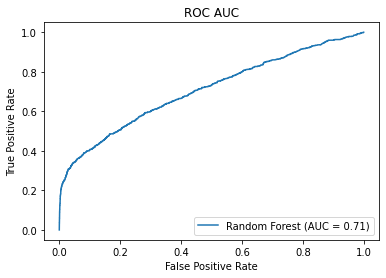

In [8]:
probs = final_rf_fit.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)
disp = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest'
).plot()
plt.title("ROC AUC")
plt.show()

We also show the feature importance plot. We see that the most important feature is the horizontal position in the pitch, followed by the angle, vertical position, and distance. We decided to include both the coordinates and distance/angle because we expected the effect of angle and distance to change based on where on the pitch the shooter is located.

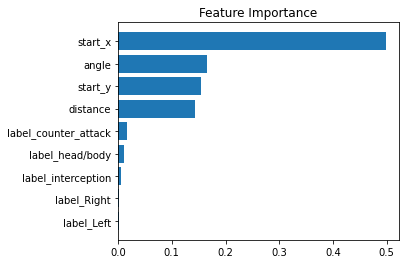

In [9]:
rf_importance = final_rf_fit.feature_importances_
df_importance = pd.DataFrame({'variable': X_train.columns, 'importance': rf_importance}).\
    sort_values('importance')

plt.barh(np.arange(len(df_importance.variable)), df_importance.importance)
plt.yticks(np.arange(len(df_importance.variable)), df_importance.variable)
plt.subplots_adjust(left=0.25)
plt.title("Feature Importance")
plt.show()

We can use the model to make probability maps for scoring on the pitch. We show a contour plot for shots and headers in a no-counter attack situation. We can see that the contours form curves around the goal as expected with distance and angle features.

For the shot plot, we see some vertical stripes of high scoring probability. This is because many of the goals in the original data were located exactly on this x-coordinate (rounded in the original dataset). In both plots we see some outlying zones far from the goal. These arise because the data has few observations in those areas and most of the observations are goals (no one would attempt a header from 3/4 of the pitch if the goalkeeper is in position). Therefore, conclusions must be made carefully.

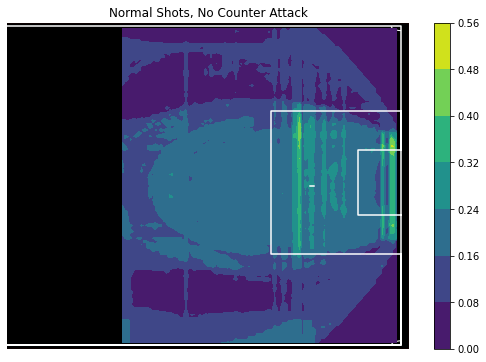

In [10]:
x_plot = np.linspace((70+0.5)*1.05, 105-0.5, 100)
y_plot = np.linspace(0+0.5, 68-0.5, 100)
xx, yy = np.meshgrid(x_plot, y_plot)
dt_plot = pd.DataFrame({'start_x': xx.flatten(), 'start_y': yy.flatten()})
dt_plot['label_Left'] = 0
dt_plot['label_Right'] = 1
dt_plot['label_counter_attack'] = 0
dt_plot['label_head/body'] = 0
dt_plot['label_interception'] = 0
dt_plot['angle'] = make_angle(dt_plot.start_x, dt_plot.start_y)
dt_plot['distance'] = make_distance(dt_plot.start_x, dt_plot.start_y)
dt_plot['goal_prob'] = final_rf_fit.predict_proba(dt_plot)[:, 1]
dt_plot['goal_prob'] = dt_plot.apply(lambda x: x['goal_prob'] if x['angle'] > 0.145 else 0, axis=1)
dt_plot['start_x'] = dt_plot['start_x']/105 * 120
dt_plot['start_y'] = dt_plot['start_y']/68 * 90

xg_array = np.array(dt_plot.goal_prob).reshape((100, 100))

draw_soccer_pitch()
plt.contourf(
    np.array(dt_plot.start_x).reshape((100, 100)),
    np.array(dt_plot.start_y).reshape((100, 100)),
    xg_array
)
plt.colorbar()
plt.title("Normal Shots, No Counter Attack")
plt.xlim(left=70)
plt.show()

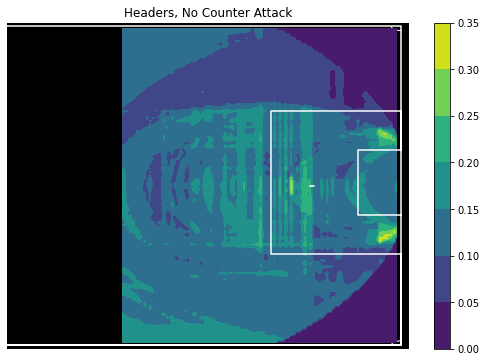

In [11]:
dt_plot = dt_plot.drop('goal_prob', axis=1)
dt_plot['label_head/body'] = 1
dt_plot['label_counter_attack'] = 0
dt_plot['goal_prob'] = final_rf_fit.predict_proba(dt_plot)[:, 1]
dt_plot['goal_prob'] = dt_plot.apply(lambda x: x['goal_prob'] if x['angle'] > 0.195 else 0, axis=1)

xg_array = np.array(dt_plot.goal_prob).reshape((100, 100))

draw_soccer_pitch()
plt.contourf(
    np.array(dt_plot.start_x).reshape((100, 100)),
    np.array(dt_plot.start_y).reshape((100, 100)),
    xg_array
)
plt.colorbar()
plt.title("Headers, No Counter Attack")
plt.xlim(left=70)

plt.show()

### Player and Team Analysis

We can look at what teams and players overperform or underperform their expected goals. Intuitively, a player that outscores his expected goals is a good forward because he get goals from low probability scoring situations. Similarly, a team that greatly outperforms expected goals may have very good strikers (or was very lucky during the season).

In [12]:
dt_shots = pd.read_pickle('data/processed/dt_shots.pkl').dropna()
dt_shots['start_x'] = dt_shots['start_x']/105 * 120
dt_shots['start_y'] = dt_shots['start_y']/68 * 90

rf_columns = [
    'start_x', 'start_y', 'label_Left', 'label_Right', 'label_counter_attack',
    'label_head/body', 'label_interception', 'angle', 'distance'
]

df_full = dt_shots.merge(df_players[['playerId', 'shortName']], on='playerId', how='left')
df_full['xg'] = final_rf_fit.predict_proba(df_full[rf_columns])[:, 1]

df_players_xg = df_full[['shortName', 'label_Goal', 'xg']].\
    groupby('shortName').\
    agg('sum').\
    sort_values('xg', ascending=False)

df_players_xg['diff'] = df_players_xg['label_Goal'] - df_players_xg['xg']

We show the top 15 performers. Most of these players are regarded as being the best forwards in the world, so the interpretation makes sense. We see some surprises like Iago Aspas and Cristhian Stuani, very good forwards that played in mid to low-table clubs in Spain.

We also see the bottom 15 performers. It is interesting to see that most of these players are not forwards, so their main role is not scoring goals. It is surprising to see Lorenzo Insigne, a very good Italian forward, on the list. However, diving deeper into his stats we found that he had a bad scoring season in 2017-2018, which is the season we use in the project.

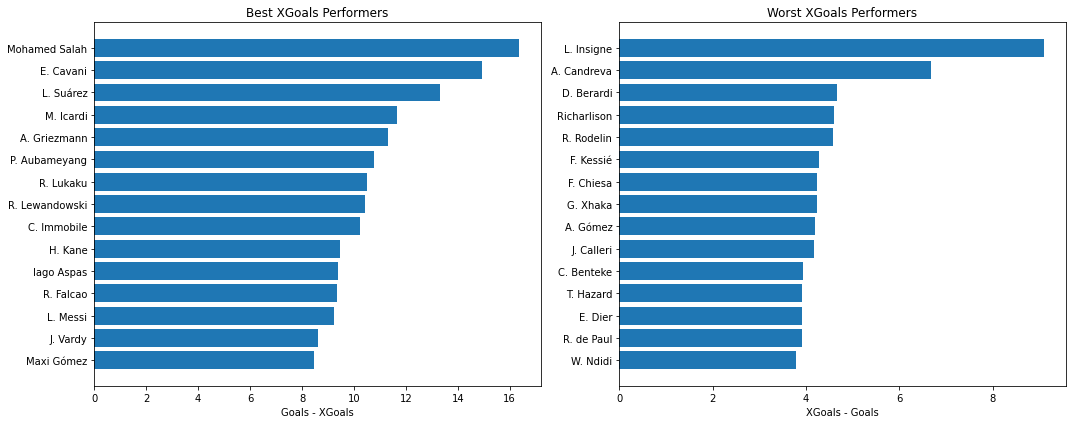

In [13]:
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.barh(
    range(15),
    df_players_xg.sort_values('diff', ascending=True).iloc[-15:, 2]
)
plt.yticks(range(15), df_players_xg.sort_values('diff', ascending=True).iloc[-15:, :].index)
plt.title('Best XGoals Performers')
plt.xlabel('Goals - XGoals')

plt.subplot(1, 2, 2)
plt.barh(
    range(15),
    abs(df_players_xg.sort_values('diff', ascending=False).iloc[-15:, 2])
)
plt.yticks(range(15), df_players_xg.sort_values('diff', ascending=False).iloc[-15:, :].index)
plt.title('Worst XGoals Performers')
plt.xlabel('XGoals - Goals')
plt.tight_layout()
plt.show()

In [14]:
id_comp = pd.read_pickle('data/processed/dt_teams.pkl')

df_teams = df_full.merge(id_comp, on='id', how='left')
df_clubs = df_teams.loc[
    (df_teams['competition'] != 'European_Championship') & (df_teams['competition'] != 'World_Cup')
]
df_wc = df_teams[df_teams['competition'] == 'World_Cup']
df_euros = df_teams[df_teams['competition'] == 'European_Championship']

df_clubs_xg = df_clubs[['label_Goal', 'xg', 'teamId']].\
    groupby('teamId').\
    agg('sum').\
    reset_index().\
    rename(columns={'index': 'teamId'})

with open('data/teams.json', encoding='unicode_escape') as f:
    teams_id = pd.read_json(f.read())
    teams_id = teams_id[['name', 'wyId']]
    teams_id = teams_id.rename(columns={'wyId': 'teamId'})
    
df_clubs_full = df_clubs_xg.merge(teams_id, on='teamId', how='left')
df_clubs_full['diff'] = df_clubs_full['label_Goal'] - df_clubs_full['xg']

We look at the best teams in terms of expected goals and the teams that outscored their expected goals by the largest amount. We notice again that the best teams in terms of expected goals are some of the best known clubs that usually dominate their domestic competitions. It is also interesting to note that Barcelona was the team with the largest difference between goals and expected goals. As we saw before, Barcelona had two of the best forwards in Messi and Luis Suarez. They won the Spanish League that year.

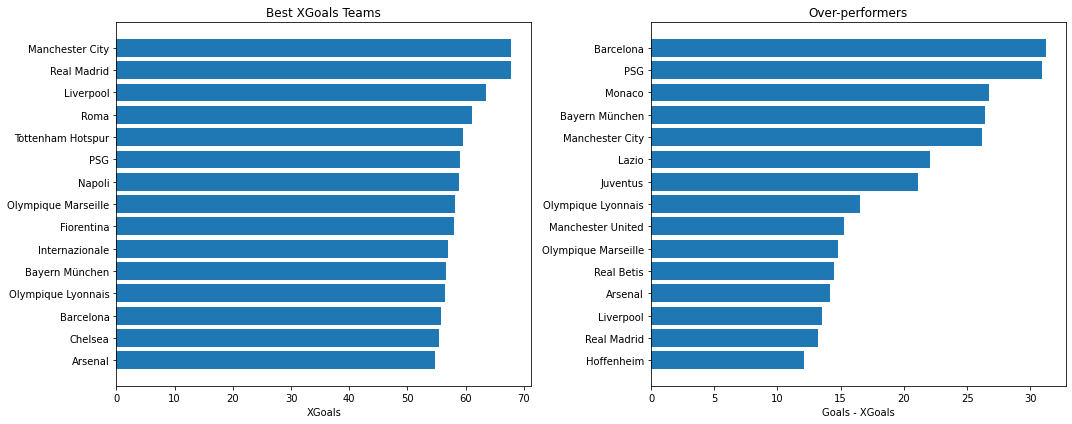

In [15]:
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.barh(
    range(15),
    df_clubs_full.sort_values('xg', ascending=True).iloc[-15:, 2]
)
plt.yticks(range(15), df_clubs_full.sort_values('xg', ascending=True).iloc[-15:, :].name)
plt.title('Best XGoals Teams')
plt.xlabel('XGoals')

plt.subplot(1, 2, 2)
plt.barh(
    range(15),
    df_clubs_full.sort_values('diff', ascending=True).iloc[-15:, 4]
)
plt.yticks(range(15), df_clubs_full.sort_values('diff', ascending=True).iloc[-15:, :].name)
plt.title('Over-performers')
plt.xlabel('Goals - XGoals')
plt.tight_layout()
plt.show()

Finally, we look at the worst teams in terms of expected goals. Some of the teams included in the worst 15 ended up being relegated at the end of the season. Some examples are Swansea City, Las Palmas, Hellas Verona, Hamburger SC, and Wolfsburg (Wolfsburg was not really relegated since they later won the relegation playoff).

The graph of underperformers also conveys some interesting information. We can see that Las Palmas was simultaneously one of the worst expected goals team and one of the worst underperformes, a recipe for disaster. Fiorentina show up in the underperformers and they also show up in the graph of best expected goals teams. We cannot help but wonder what would have been of Fiorentina with better forwards since that season they missed classification to European competitions by only 3 points. We also note that many relegated teams show up in the underperformers graph like Las Palmas, Benevento, Malaga, Toulouse, Hamburger, and Deportivo La Coruna.

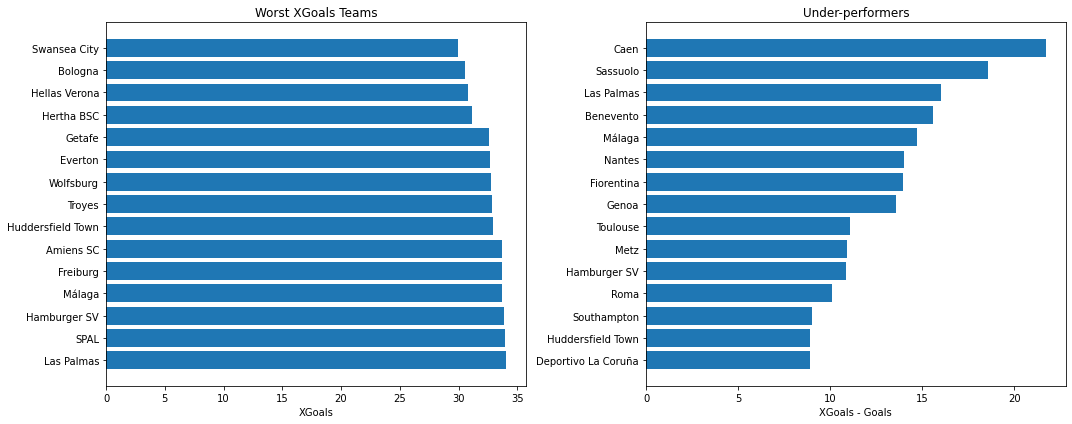

In [16]:
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.barh(
    range(15),
    df_clubs_full.sort_values('xg', ascending=False).iloc[-15:, 2]
)
plt.yticks(range(15), df_clubs_full.sort_values('xg', ascending=False).iloc[-15:, :].name)
plt.title('Worst XGoals Teams')
plt.xlabel('XGoals')

plt.subplot(1, 2, 2)
plt.barh(
    range(15),
    abs(df_clubs_full.sort_values('diff', ascending=False).iloc[-15:, 4])
)
plt.yticks(range(15), df_clubs_full.sort_values('diff', ascending=False).iloc[-15:, :].name)
plt.title('Under-performers')
plt.xlabel('XGoals - Goals')
plt.tight_layout()
plt.show()

## IV. Passing

### a. Introduction

In conjunction with the expected goals modeling, we wanted to understand how passing strategies might differ between leagues. Our idea was that looking at passes from different perspectives would add another layer of complexity to understanding different advantages that are unique to a country's league that might lead to a higher likelihood of scoring a goal. With a larger bandwith, we would have liked to incorporate a more quantitative approach to studying the passing strategies and even integrate that into the expected goals modeling. But for the sake of this project, we limited the scope to delving more into how to best represent passes visually and what insights can be revealed from the following plots. 

### b. Data Processing

#### (i) Data reading

First, we read in the necessary data files and did some cursory cleaning so that we can merge together. We separated out the data cleaning for the previous section since the use cases were very different - this section was much more about visualizations and summary statistics, whereas the Expected Goals model only required a few of the data points mainly from the `Events` dataset. We felt that it was more efficient and easier to manage to keep it separate rather than make a centralized dataframe for which the data processing time would take much longer, and then subset and pare down for each of the use cases. 

The method in which we read the data and clean is very similar to that of the previous section, ie reading each of the json files into a pandas dataframe from the `/data` directory. Data on matches had separate files for each league contained in the `/data/matches` folder, so we used `glob.glob()` function to determine the json files within the folder dynamically (similar approach as the processing for Denny's last semester) and concatenated each of the converted dataframes together. Where files on events had to be contained in a zipfile to compress the file sizes so we could upload to git, we used the `zipfile` package to unzip and read in each of the json files in the folder and concatenated. In reading the data, we had to change the default encoding to `unicode_escape` so that it would process for the accented text for the players and club names. 

The above is stored as `read_data()` in the `passing_fxns` file. 

#### (ii) Data cleaning

For data cleaning, this mostly consisted of removing unnecessary columns, renaming columns to follow a snake_case convention, and expanding columns we needed where values were embedded in dictionaries. For the last point, we took the column and used `apply(pd.Series)` across the column axis which split the dictionaries into separate columns. We took the resulting columns that we wanted and concatenated back onto the original dataframe (with that column dropped). Also inn this step, we filtered for teams that are labeled as 'club'. When we later merge the dataset, this will essentially remove the data points for national teams and the world championships. This way, our later data analysis will be consistent across the league season, as opposed to also combining data from matches where the composition of teams is different, ie national vs league, in addition to other factors. 

The above is stored as `clean_data()` in the `passing_fxns` file.

#### (iii). Make main dataframe

Once we had each of the dataframe cleaned and processed, we then made the intended dataframe, which contained data on each pass and shot across leagues. This main dataframe will serve as the basis of the following analysis. This involves filtering the `events` dataframe for only events labeled as pass or shot, creating position coordinate columns, and merging with other dataframes as needed in order to get more identifying information. 

For creating the position columns, this included taking the columns `positions` separately and using a series of `tolist()` functions to expand the nested dictionary (which had three levels) to have the start and end x and y position (in percentage terms) of each event. Once we had these four columns in a separate dataframe, we concatenated them back onto the main dataframe. Since we had to filter the positions for not null coordinates (supposedly passes that were stopped mid-play or went out of bounds), the indices were not perfectly matched between the two dataframes. To handle that, we stored the indices of the position columns that corresponded to the original and when concatenating, we filtered the main dataframe for those indices to match up the rows. 

For each of the four position columns, we converted them from percentage terms to actual coordinates using the same dimensions (125x68) as the previous section. Additionally, we noticed when conducting some EDA that there were shots that had destination of (0,0). Since the data was constructed so that all teams attack towards the right side of the constructed field, that meant that these shots had destination at the top left corner of their own side. We felt confident that this was an erroneous data construction, so we reassigned these positions to the middle of the opponent's goal (the label associated with the event would inform if this shot was an actual goal, so the data was not misrepresented in this way). 

We also created a `pass_length` column that computed the distance between the start and end coordinates of each pass/shot. Then, we merged this dataframe with the other dataframes using the various id columns. The resulting dataframe had an unique row for each event by label - this means that there could be more than one row per event based on how many tags there were (ie labels characterizing the event). This long format is helpful for our EDA but is later reformatted to have one row per event later in the analysis. 

Finally, we reassign Wales and Monaco to England and France, respectively. Some teams identified their countries as the former but to streamline our later categories, we lumped them to the same countries as other teams in their league. 


This is stored into `get_pass_shot_data()` which calls the above two functions in the process. 

In [17]:
# make main pass/shots df 
ps_df = get_pass_shot_data()

Starting
Finished reading data
Finished cleaning data
Finished making position columns
Finished merging data


### c. EDA

We first looked at some higher level summary statistics. The following tables and histograms broadly showed the distribution of passes across qualitative variables (type of pass, position of passer) as well as quantitative (distance of pass, proportion of passes by field position) in attempt to uncover where differences between countries might reside. The exploratory data analysis from a high level confirmed our intuition broadly speaking, but we found that when looking in aggregate, there appeared little difference in the aforementioned factors across countries. 

In [18]:
# just get pass data
p =  ps_df[ps_df.event_name == 'Pass'].copy()

#### (i) Pass type counts by player position

The breakdown in the table shown below is in line with our intuition - simple passes are the most frequent type, followed by crosses, head passes, and high passes. Additionally, defenders and midfielders tend to pass the most, which makes sense since the control of the field in general is maintained midfield between these player positions, with quick bursts passed towards forwards. While these results are not particulary exciting, they do confirm that there are not any major discrepancies in the data we are using.

In [19]:
# types of passes by player
pd.DataFrame(p.groupby(['position']
                      ).sub_event_type.value_counts()
            ).rename({'sub_event_type':'count'}, axis=1
           ).reset_index(
            ).pivot(index='position', columns='sub_event_type', values='count'
                   ).fillna(0)

sub_event_type    Cross  Hand pass  Head pass  High pass   Launch  \
position                                                            
Defender        16948.0        2.0    34929.0    47788.0   9877.0   
Forward          9426.0        5.0     9960.0     6003.0    631.0   
Goalkeeper          0.0     9819.0       96.0     6150.0  17394.0   
Midfielder      16924.0        5.0    22358.0    32162.0   3777.0   

sub_event_type  Simple pass  Smart pass  
position                                 
Defender           385116.0      3696.0  
Forward            119868.0      6499.0  
Goalkeeper          20019.0         1.0  
Midfielder         394487.0     11483.0

#### (ii) Pass type counts by position and country

Now starting to explore whether there exists any difference between countries, we replicate the above table but grouped by country with each value showing the proportion for each country. The blue shading for each of the cells is meant to highlight that the distribution of types of passes and positions are very similar across countries, where we see dark blue for simple passes in midfielders, we see this for each of the corresponding cell in that column, and so on. 

In [20]:
# make pass by position and country 
ppc = pd.DataFrame(p.groupby(['country', 'position']
                      ).sub_event_type.value_counts()
            ).rename({'sub_event_type':'count'}, axis=1
           ).reset_index()
# take out goalkeeper relatedd 
ppc2 = ppc.loc[(ppc.position != 'Goalkeeper') & (ppc.sub_event_type != 'Hand pass')].copy()
# column level changes 
ppc2.count = ppc2['count'].astype(int)
ppc2['prop'] = ppc2.count / ppc2.groupby('country')['count'].transform('sum')
# pivot to wide format and fill na with 0 
ppc2 = ppc2.pivot(index=['country', 'position'], columns='sub_event_type', values='prop').fillna(0)

In [21]:
# make table with colored background
ppc2.style.background_gradient(cmap='Blues').format(precision=2)

#### (iii) Prop. of distance of passes by country

Given that we don't see any differences outright in types of passes or even proportion of passes by each type of player position, we examine the distribution of pass length across countries (including grouped by player position). As mentioned in the introduction, there are generalities made on each league's and country's playing style, one facet is with having long over the field passes vs short passes traversing along the field. The histograms below show that from an aggregate view, there are no clear differences in passing length. For the most part we see that pass length peaks around 20 meters with a right tail towards 75+ meters. 

# HELP ADD LEGEND

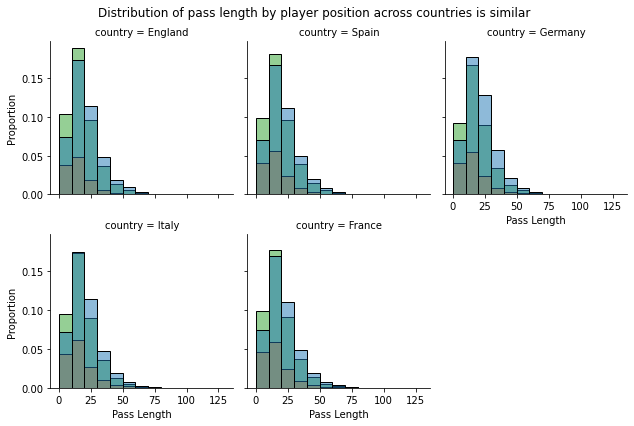

In [36]:
# take out goalkeeper 
p_ng = p.loc[(p.position != 'Goalkeeper') & (p.sub_event_type != 'Hand pass')]
# fix color order for position
hue_order = ['Defender', 'Forward', 'Midfielder']

# graph 
g = sns.FacetGrid(p_ng, col="country", col_wrap=3)
g.map_dataframe(sns.histplot, x="distance", binwidth=10, stat='probability', hue='position', hue_order = hue_order)
g.fig.suptitle('Distribution of pass length by player position across countries is similar')
g.fig.subplots_adjust(top=0.9)
g.set_xlabels('Pass Length')
g.set_ylabels('Proportion')
## ADD LEGEND !!!!!

#### (iv) Histogram of pass counts by country

Now, we wanted to start looking at passes from a positional perspective. For these graphs and the following representations of the field, the attacker's directions will always move towards the right, so any shots to score will be made on the right hand side of the field (regardless of field switches during halftime in reality). At a high level, the below graphs show the counts of passes for bins colored by frequency. Each of the graph shows that passes originate from the midfield with higher density at the quadrants of either side of the field as well as the center of the field (presumably because of kickoffs), creating an almost pseudo-butterfly imprint. 

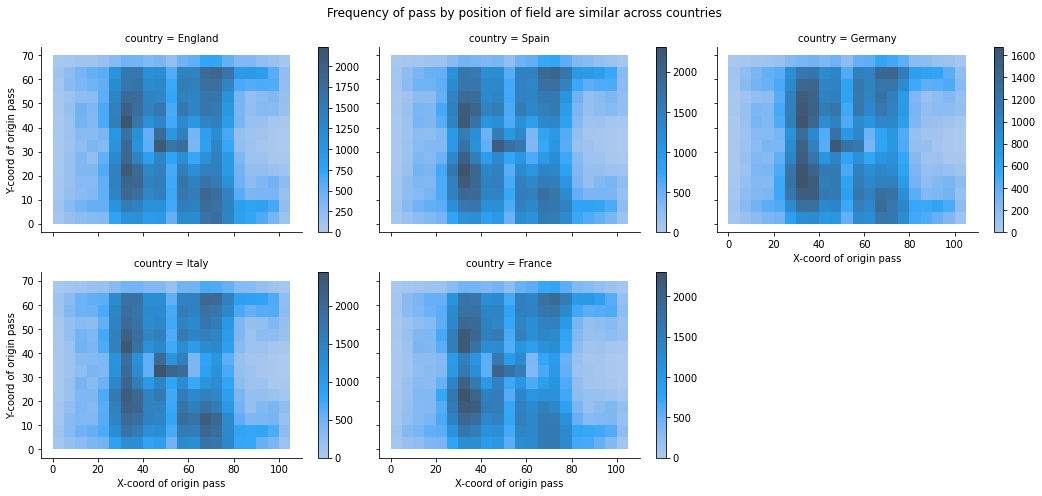

In [23]:
# facet histogram of x,y by country 
h = sns.FacetGrid(p_ng, col="country", col_wrap=3, height=3.5, aspect=1.4)
h.map_dataframe(sns.histplot, x="origin_x", y="origin_y", binwidth=5, cbar=True)

# add plot formatting 
h.fig.suptitle('Frequency of pass by position of field are similar across countries')
h.fig.subplots_adjust(top=0.9)
h.set_xlabels('X-coord of origin pass')
h.set_ylabels('Y-coord of origin pass')

### d. Average distance of pass based on origin position by country

Now having this cursory understanding of how the distribution of data lies across countries, we now wanted to dig deeper into how to visualize passes. First, we looked into the average pass length based on the position of the field. In order to do this, we used `pd.cuts()` to create a 40x40 grid of the field so that we could aggregate passes into these 1600 bins. This way, we would be able to create averages over these bins since otherwise there would be so much variability between pass locations to be able to glean trends. 

When we first plotted the faceted heatmaps, on a raw average level, the graphs tended to look very similar (as indicated by the color for the magnitude of the pass length). We then looked at the deviances from the overall average pass length at each of the pass lengths. This way, while most of the pass lengths are generally similar across countries, we would be able to view relative differences between countries. We then use seaborn's `heatmap()` function where the center was around 0 and a diverging color palette. This data processing and graphing resides in the `plot_pass_length_heatmap()` function.

# HELP FIX GERMANY PLOT SIZE

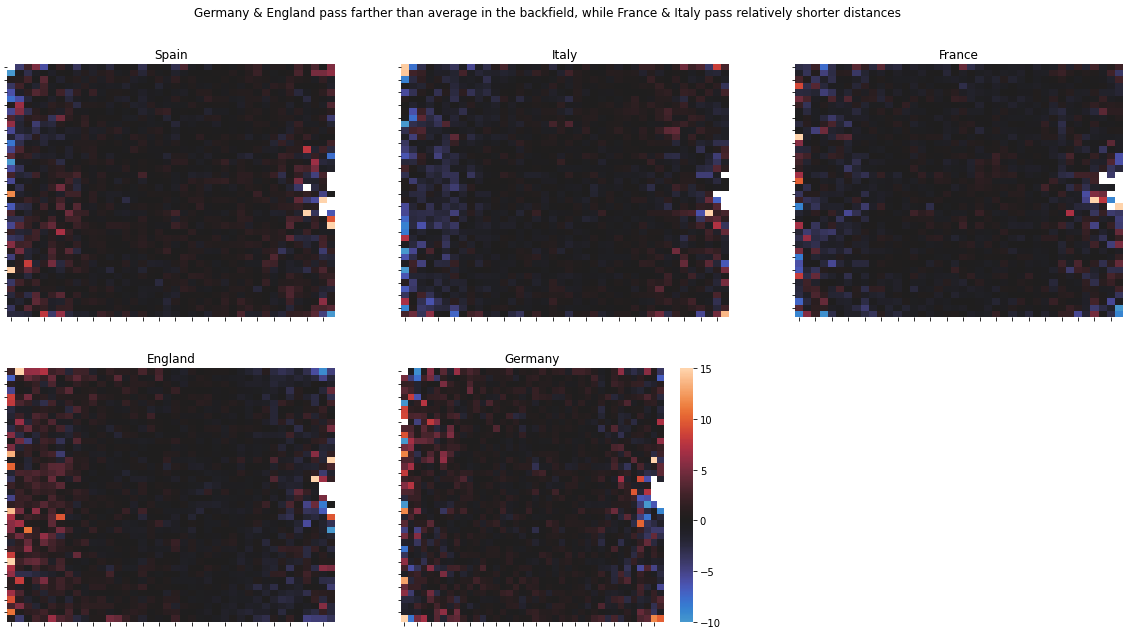

In [24]:
plot_pass_length_heatmap(p)

The heat maps above illustrate passing length based on the origin location of the pass, faceted by each league. Each heat map is constructed in such a way so that the far-right side of the plot represents the opposing goal (the goal a team wants to score on), and the far-left side of the plot is the goal that a team is defending. The color of each square on the heat map corresponds to the normalized average pass length from that position on the field. Red squares indicate that passes from that location are typically longer in terms of distance compared to the average pass length, and similarly blue squares indicate that passes from that location are shorter than average. Areas of black indicate that passes are approximately average length from that location.

Looking at the plots, we can see that England and Germany typically make longer passes (red squares) originating from the back (left side) when compared to Italy, which contains mostly blue areas in the defensive regions. This can be best described by traditional English and German tactics that make use of the counterattack, which is typically a long, quick pass from a defender to an offender/striker on the opposite end of the field. The objective of a counterattack is to try to quickly change the position of by field and create a scoring opportunity by catching the opposing team off guard and with minimal defenders behind the ball. Such a feat makes English and German soccer so exciting to spectate, since every defensive play can be rapidly turned into an offensive ploy, and games are typically played at a high intensity. On the opposite end of the spectrum is Italy, where defenders primarily make many short passes, and are more possession and defensive minded, rather than the attacking mindsets seen on the German and English plots.

### e. Passes by field position

#### (i) Making summary data

We now wanted to graph individual passes, and we used a similar aggregation approach with a 40x40 grid like the previous section so that we could filter accordingly for frequency. For each of the x & y bins separately, we found rows in which either the origin and destination of the pass fell in between the bin. Then, we created columns that would set the x,y value as the midpoint of the bin the point lay within. 

For the following graphs, we take advantage of a `draw_pitch()` function derived from a function found in git, the specific reference is in the description of the function. The resulting `pp_avg` dataframe will be the basis for the following graphs.

In [25]:
# get summary data
pp_avg = get_summary_pass_data(ps_df, 40)

#### (ii) Plot passes by country, colored by frequency

For each country, we plot the passes from `pp_avg` dataframe using the newly made origin and destination coordinates. For this set of graphs and the subsequent ones, when filtering for frequency, we use proportion rather than raw counts. There were varying counts in passes between the countries but there were also varying counts in matches, so we couldn't conclude that the counts in passes were due to actual differences in strategies. We calculated the proportion of counts for each of the 1600 positions for each country. For the sake of not having to work with very small fractions, we multipled the proportion column with a large constant that was approximately equal to the total number of passes. 

For this set, we filtered for passes with very low frequency so that the graphs would not be virtually solid with indistinguishable lines. In order to choose this, we graphed the distribution of the `n_prop` column and ballparked the value in which there were about ~5000 points for each country. The lines were colored based on the `n_prop` column, with white being the least frequent in the filtered data, and then in reverse rainbow order with red representing the most frequent occurrence of passes. 

# HELP ADD LEGEND

Plotting England points
Plotting France points
Plotting Germany points
Plotting Italy points
Plotting Spain points


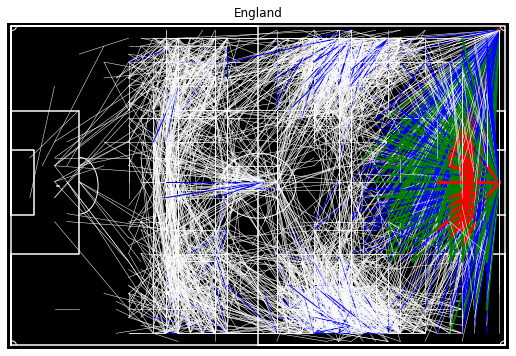

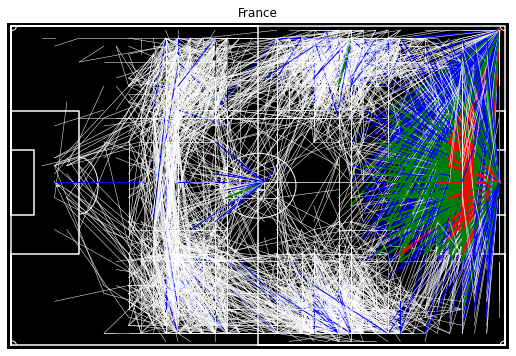

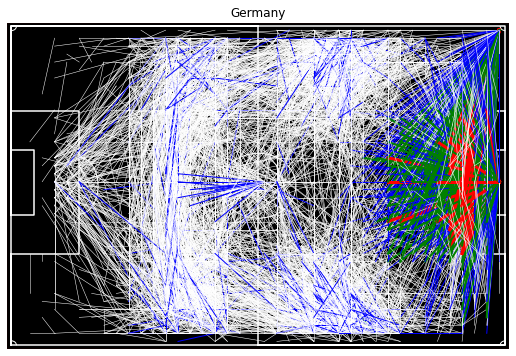

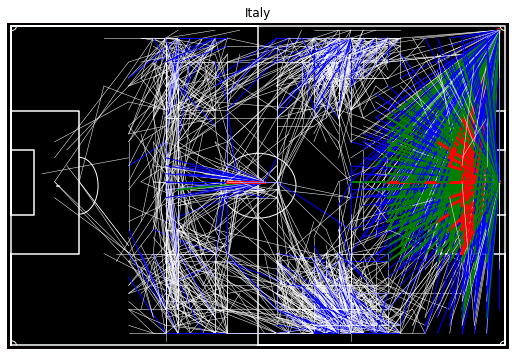

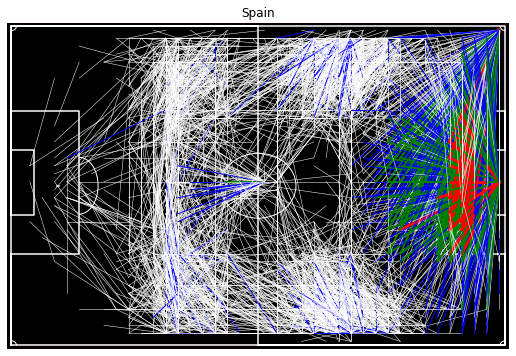

In [26]:
plot_pass_by_country(pp_avg)

The line plots above depict the most frequent passing routes from each league based on the location of where the pass originated from and was delivered to. White lines indicate there are less than 50 occurrences of that one passing route, yellow lines indicate there are between 50 and 100 occurrences, green lines indicate between 100 and 150 occurrences, and blue lines indicate greater than 150 occurrences of that passing route. It should be noted that most of the blue, green, and red lines near the attacking (far-right) goal are the result of shots, corner kicks and penalty kicks. 

The first thing comes to mind is the amount of variability in the Germany plot, which makes it difficult to discern what the typical passing pattern is for German teams. This is because it appears that the entire region between penalty areas is covered in some combination of a white line, meaning that no single passing patterns are dominant. While this doesn’t necessarily mean that Germany passes less than the other leagues, this conveys that there are no clear and consistent passing pasterns among the 18 teams in the German league. On the contrast, the Italian plot is much less busy than the German one and you can clearly see a discernable pattern for Italy.  As seen in the plots, Italian teams pass relatively consistently across the league, by making use of short passes among their defenders, before working the ball out wide to their wings. Italian teams are known for being patient, meaning that teams are more systematic in their approach to scoring, and will only attack when the perfect opportunity arises. It can also be seen that goalkeepers in the Italian league are rarely involved in passing plays, since teams in this league play so defensively, meaning that passing to their respective goalkeeper is rarely ever required. This drastically differs from the German league, where goalkeepers are much more involved in passing routes, which is typically due to German defenders playing higher up on the pitch near the midfield line, and the constant threat of opposing counterattacks. Such an observation is supported by Manuel Neuer, the German goalkeeper for Bayern Munich, who has been dubbed the “sweeper-keeper” because of how he’s seen as a fifth defender for his team, due his extensive involvement in non-penalty area plays. 

#### (iii) Plot passes by country, colored by player position


We now take the same construction as the previous graph, but now we color the lines based on the position of the player who initiated the pass. For these graphs, the filter of frequency is much harsher - both numerically since there is an extra grouping variable of position but also by design so we can better see where the most likely movements for the player positions. 

# HELP ADD LEGEND

Plotting England points
Plotting France points
Plotting Germany points
Plotting Italy points
Plotting Spain points


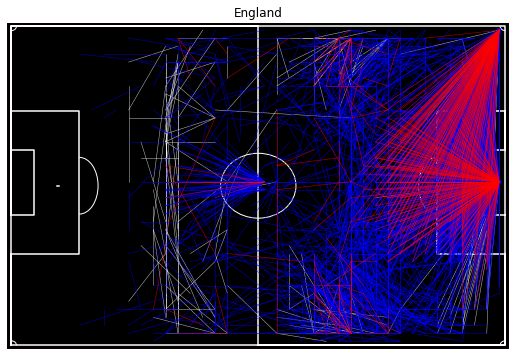

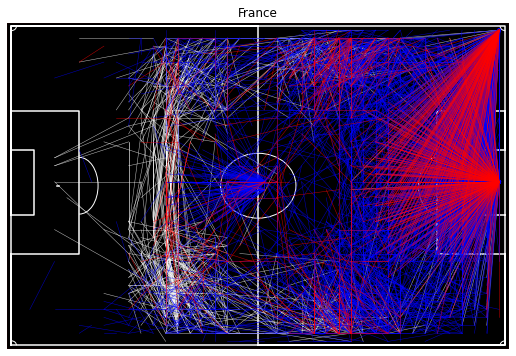

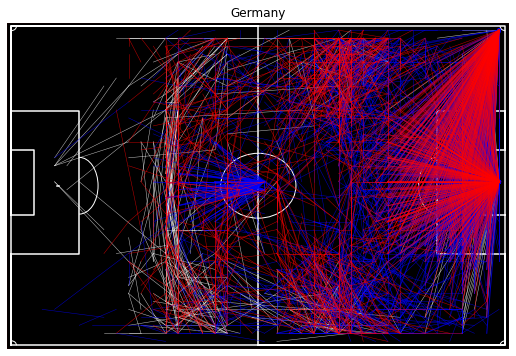

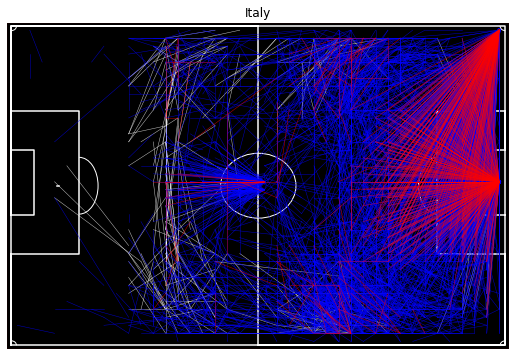

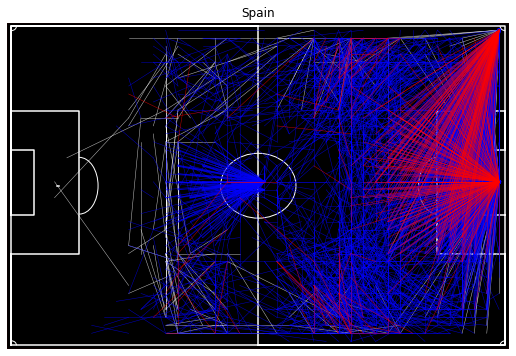

In [27]:
plot_pass_by_country_role(pp_avg)

# ADD WRITEUP

#### (iv) Plot most frequent pass by field position


Finally, we wanted to more generally examine frequent movements across the field for each league. To accomplish this, we reformat the field into a 10x10 grid (as opposed to 40x40 in earlier graphs), and we filter for the unique pass (start to end coordinates) that occurs the most frequent for each of the 100 origin bins. Instead of lines, we use arrows to show direction of movement, and similarly color the arrows based on the frequency as described for the graphs in (ii). 

# HELP ADD LEGEND

Plotting England points
Plotting France points
Plotting Germany points
Plotting Italy points
Plotting Spain points


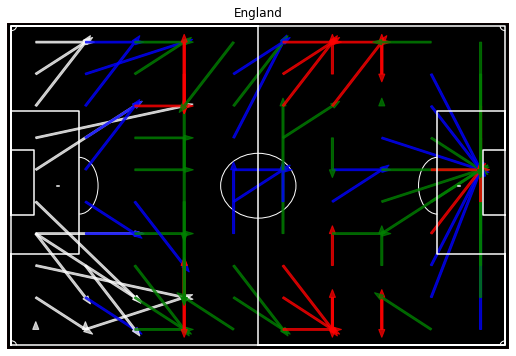

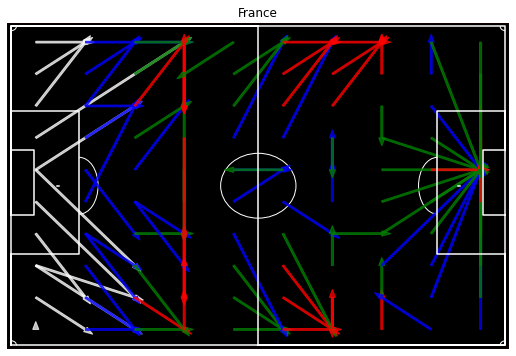

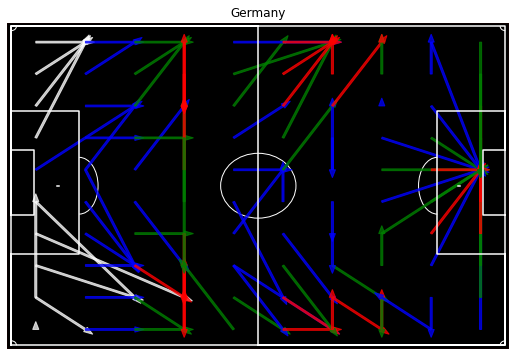

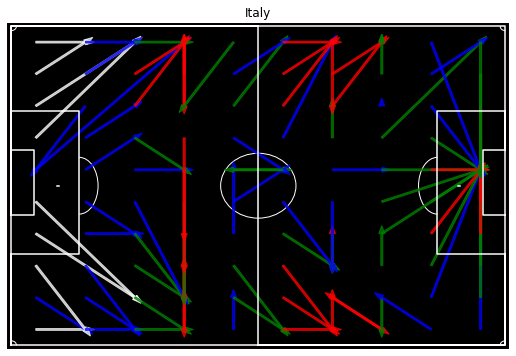

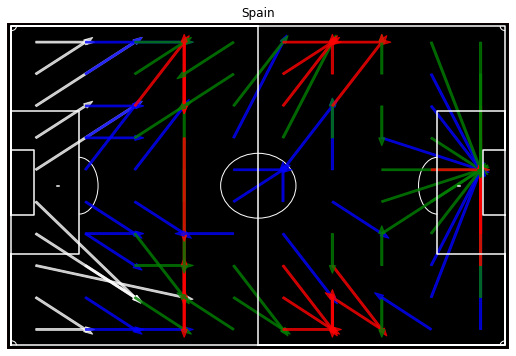

In [28]:
plot_freq_pass(ps_df)

# ADD WRITEUP